In [1]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

## Problem Statement

We want to predict the possible tags given a question and its associated title

## Let's have a look at the tags

In [2]:
# Read in the tage and have a look
tags_df = pd.read_csv('../Datasets/kaggle_stackoverflow/Tags.csv')
tags_df.head(10)

,Id,Tag
0,1,bayesian
1,1,prior
2,1,elicitation
3,2,distributions
4,2,normality
5,3,software
6,3,open-source
7,4,distributions
8,4,statistical-significance
9,6,machine-learning


In [3]:
# Have a look at the some of the tags
tag_count = tags_df.groupby(['Tag'])
tag_count.count()

,Id
Tag,
2d,1
2sls,66
ab-test,107
abbreviation,4
abc,19
...,...
z-statistic,40
z-test,116
zero-inflated,21


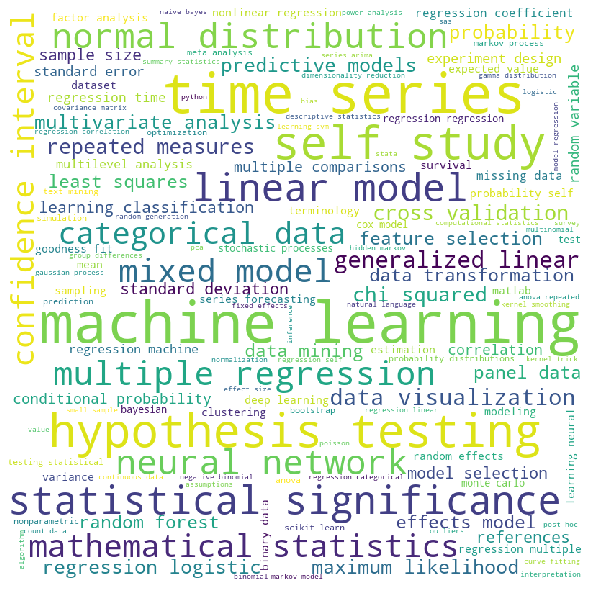

In [4]:
# Get all the tags for the wordcloud
tags = ' '.join(tags_df['Tag'])

# Create a wordcloud from the tags
%matplotlib inline
stopwords = set(STOPWORDS)
wordcloud_tac_repro = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(tags) 
             
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_tac_repro) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

#### It looks like Machine Learning is the most widely used tag.

## Now let's have a look at the questions

In [5]:
# Read in the questions data and have a look
questions_df = pd.read_csv('../Datasets/kaggle_stackoverflow/Questions.csv', encoding = 'ISO-8859-1')
questions_df.head(10)

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demog...
2,22,66.0,2010-07-19T19:25:39Z,208,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...
3,31,13.0,2010-07-19T19:28:44Z,138,What is the meaning of p values and t values i...,<p>After taking a statistics course and then t...
4,36,8.0,2010-07-19T19:31:47Z,58,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n..."
5,93,61.0,2010-07-19T20:17:07Z,6,Robust nonparametric estimation of hazard/surv...,<p>We're trying to use a Gaussian process to m...
6,95,57.0,2010-07-19T20:21:35Z,7,How Large a Difference Can Be Expected Between...,<p>I have been using various GARCH-based model...
7,103,5.0,2010-07-19T20:33:26Z,42,What is your favorite data visualization blog?,<p>What is the best blog on data visualization...
8,113,39.0,2010-07-19T20:54:23Z,10,What are some good frameworks for method selec...,<p>I have been looking into theoretical framew...
9,114,8.0,2010-07-19T21:00:53Z,35,What statistical blogs would you recommend?,<p>What statistical research blogs would you r...


In [6]:
# Let's have a look at question with Id 6
id = 36
question = questions_df.query(f'Id == {id}')
question

,Id,OwnerUserId,CreationDate,Score,Title,Body
4,36,8.0,2010-07-19T19:31:47Z,58,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n..."


In [7]:
question['Title'].iloc[0]

'Examples for teaching: Correlation does not mean causation'

In [8]:
question['Body'].iloc[0]

'<p>There is an old saying: "Correlation does not mean causation". When I teach, I tend to use the following standard examples to illustrate this point:</p>\n\n<ol>\n<li>number of storks and birth rate in Denmark;</li>\n<li>number of priests in America and alcoholism;</li>\n<li>in the start of the 20th century it was noted that there was a strong correlation between \'Number of radios\' and \'Number of people in Insane Asylums\'</li>\n<li>and my favorite: <a href="http://en.wikipedia.org/wiki/File%3aPiratesVsTemp%28en%29.svg">pirates cause global warming</a>.</li>\n</ol>\n\n<p>However, I do not have any references for these examples and whilst amusing, they are obviously false.</p>\n\n<p>Does anyone have any other good examples?</p>\n'

In [9]:
# Now let's look at the tags
tags = tags_df.query(f'Id == {id}')
tags

,Id,Tag
53,36,correlation
54,36,teaching


## Now let's do some Data Wrangling

#### Let's start with removing rare tags

In [10]:
# Have a look at the least frequent tags
tags_count_df = tags_df.groupby(['Tag']).count()
tags_count_df_asc = tags_count_df.sort_values(by=['Id'])
tags_count_df_asc.query('Id >= 3').head()

,Id
Tag,
chi-distribution,3
reversible-jump,3
gpu,3
clara,3
generalized-eta-squared,3


In [11]:
# Have a look at the most frequent tags
tags_count_df_desc = tags_count_df.sort_values(by=['Id'], ascending=False)
tags_count_df_desc.head()

,Id
Tag,
r,13236
regression,10959
machine-learning,6089
time-series,5559
probability,4217


In [12]:
# Use just the top 100 tags
num_classes = 10
grouped_tags = tags_df.groupby("Tag").size().reset_index(name='count')
most_common_tags = grouped_tags.nlargest(num_classes, columns='count')
tags_df['Tag'] = tags_df.Tag.apply(lambda tag : tag if tag in most_common_tags.Tag.values else None)
tags_df = tags_df.dropna()

#### Now lets combining the Title, Body and Tags

In [13]:
# Create a function to strip html tags
def strip_html_tags(body):
    regex = re.compile('<.*?>')
    return re.sub(regex, '', body)

In [14]:
# Strip the html tags
questions_df['Body'] = questions_df['Body'].apply(strip_html_tags)

In [15]:
# Have a look at the first Body
questions_df['Body'][0]

'Last year, I read a blog post from Brendan O\'Connor entitled "Statistics vs. Machine Learning, fight!" that discussed some of the differences between the two fields.  Andrew Gelman responded favorably to this:\n\nSimon Blomberg: \n\n\n  From R\'s fortunes\n  package: To paraphrase provocatively,\n  \'machine learning is statistics minus\n  any checking of models and\n  assumptions\'.\n  -- Brian D. Ripley (about the difference between machine learning\n  and statistics) useR! 2004, Vienna\n  (May 2004) :-) Season\'s Greetings!\n\n\nAndrew Gelman:\n\n\n  In that case, maybe we should get rid\n  of checking of models and assumptions\n  more often. Then maybe we\'d be able to\n  solve some of the problems that the\n  machine learning people can solve but\n  we can\'t!\n\n\nThere was also the "Statistical Modeling: The Two Cultures" paper by Leo Breiman in 2001 which argued that statisticians rely too heavily on data modeling, and that machine learning techniques are making progress by i

In [16]:
# Combine the Title and Body
questions_df['Text'] = questions_df['Title'] + ' ' + questions_df['Body']

In [17]:
# Have a look at the first Text
questions_df['Text'][0]

'The Two Cultures: statistics vs. machine learning? Last year, I read a blog post from Brendan O\'Connor entitled "Statistics vs. Machine Learning, fight!" that discussed some of the differences between the two fields.  Andrew Gelman responded favorably to this:\n\nSimon Blomberg: \n\n\n  From R\'s fortunes\n  package: To paraphrase provocatively,\n  \'machine learning is statistics minus\n  any checking of models and\n  assumptions\'.\n  -- Brian D. Ripley (about the difference between machine learning\n  and statistics) useR! 2004, Vienna\n  (May 2004) :-) Season\'s Greetings!\n\n\nAndrew Gelman:\n\n\n  In that case, maybe we should get rid\n  of checking of models and assumptions\n  more often. Then maybe we\'d be able to\n  solve some of the problems that the\n  machine learning people can solve but\n  we can\'t!\n\n\nThere was also the "Statistical Modeling: The Two Cultures" paper by Leo Breiman in 2001 which argued that statisticians rely too heavily on data modeling, and that m

In [18]:
# Combine the Text and the Tags
total_df = pd.merge(questions_df, tags_df, on='Id', how='inner')
concat_tag_df = total_df.groupby(['Id'])['Tag'].apply(','.join).reset_index()
combined_df = pd.merge(questions_df, concat_tag_df, on='Id', how='inner')[['Text','Tag']]
combined_df.head(5)

,Text,Tag
0,The Two Cultures: statistics vs. machine learn...,machine-learning
1,What is the meaning of p values and t values i...,hypothesis-testing
2,How Large a Difference Can Be Expected Between...,time-series
3,What are some good frameworks for method selec...,machine-learning
4,Statistical classification of text I'm a progr...,classification


Now let's convert the tags into the correct format. As it is a multi-label classification, we need to convert our target label into a binarised vector with multiple bits set as 1. ‘MultiLabelBinarizer’ of ‘scikit-learn’ can do that.

In [19]:
# Encode the tags
y = []
for index, row in combined_df[['Tag']].iterrows():
    y.append(set(row['Tag'].split(',')))

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(y)

# Have a look at the tags
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [20]:
# Comfirm the number of tags used
Y.shape

(44928, 10)

#### Now let's encode the Text

In [21]:
# Create a count representation of Text
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(combined_df['Text'])

In [22]:
# Create the tf-idf representation of Text
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_counts)

#### Now let's split the data into train and test sets

In [23]:
# Create the train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1000)

## Now let's try some Modelling

In [24]:
# Try out a bunch of models
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression(solver='lbfgs')
svc = LinearSVC()
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100)
gbc = GradientBoostingClassifier(n_estimators=100)

In [25]:
# Create function to print out model performance
def print_performance(y_pred, y_test, classifier):
    print(f'Classifier: , {classifier.__class__.__name__}')
    print(f'Hamming loss: {hamming_loss(y_pred, y_test)}')
    print('---')

#### Try one vs rest strategy

In [26]:
# Create the models and see their performance
for classifier in [sgd, lr, svc, knn, rf, gbc]:
    model = OneVsRestClassifier(classifier)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_performance(y_pred, y_test, classifier)

Classifier: , SGDClassifier
Hamming loss: 0.10494123931623932
---
Classifier: , LogisticRegression
Hamming loss: 0.07604166666666666
---
Classifier: , LinearSVC
Hamming loss: 0.07492877492877494
---


KeyboardInterrupt: 